<a href="https://colab.research.google.com/github/Alemzhan-A/ML_MNIST/blob/main/MNIST_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## 1) Скачивание датасета mnist



In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
from torch.utils.data import DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from sklearn import metrics

100%|██████████| 9912422/9912422 [00:00<00:00, 128195066.68it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 96215801.29it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 46290487.39it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21261750.86it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



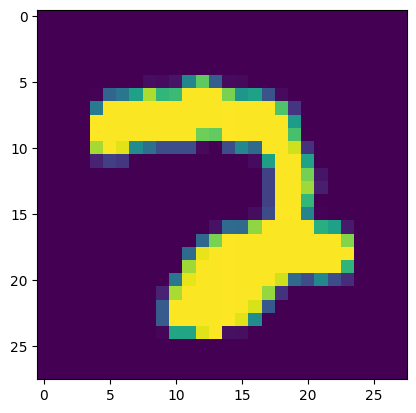

In [ ]:
mnist_train = tv.datasets.MNIST(root='mnist',train=True, download=True,transform = tv.transforms.ToTensor())
mnist_test = tv.datasets.MNIST(root='mnist',train=False, download=True,transform = tv.transforms.ToTensor())
plt.imshow(mnist_train[120][0].numpy()[0])

In [ ]:
dataloader = DataLoader(mnist_train, batch_size=50, shuffle=True)
for i, (X, y) in enumerate(dataloader):
    print(f'Batch {i}')
    print(f'X.shape = {X.shape}')
    print(f'y.shape = {y.shape}')
    break
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Batch 0
X.shape = torch.Size([50, 1, 28, 28])
y.shape = torch.Size([50])


## 2) Напишите модель, подобную модели с первой части семинара.

In [ ]:
class Mnist_nn(nn.Module):
  def __init__(self):
    super().__init__()
    self.flat = nn.Flatten()
    self.linear1 = nn.Linear(28*28, 100)
    self.linear2 = nn.Linear(100, 10)
    self.act = nn.Sigmoid()

  def forward(self, x):
    out = self.flat(x)
    out = self.linear1(out)
    out = self.act(out)
    out = self.linear2(out)

    return out
model = Mnist_nn()

In [ ]:
params_count = 0
for param in model.parameters():
    params_count += torch.numel(param)
params_count

79510

## 3) Выведите summary модели.

In [ ]:
model.to('cuda')
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
           Sigmoid-3                  [-1, 100]               0
            Linear-4                   [-1, 10]           1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.30
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


# 4) Обучите модель, добавив коллбек построения графиков обучения, напишите выводы: сошлась ли модель по итогам обучения.

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
model = model.to(device)
loss_fn = loss_fn.to(device)

In [ ]:
def run(model, dataloader, loss_function, optimizer=None):
    if optimizer == None:
        model.eval()
    else:
        model.train()

    total_loss = 0

    for X, y in dataloader:
        pred = model(X)
        loss = loss_function(pred, y)
        total_loss += loss.item()
        if optimizer != None:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    return total_loss / len(dataloader)

In [ ]:
from IPython.display import clear_output

def show_losses(train_loss_hist, test_loss_hist):
    clear_output()

    plt.figure(figsize=(12,4))

    plt.subplot(1, 2, 1)
    plt.title('Train Loss')
    plt.plot(np.arange(len(train_loss_hist)), train_loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.title('Test Loss')
    plt.plot(np.arange(len(test_loss_hist)), test_loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.show()

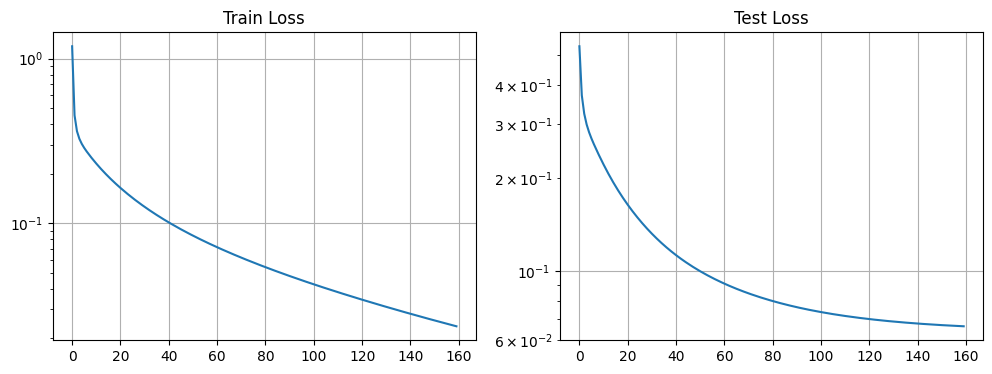

In [ ]:
BATCH_SIZE = 100
NUM_EPOCHS = 160

# your code here
train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE)
test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE)

train_loss_hist = []
test_loss_hist = []

for i in range(NUM_EPOCHS):
    train_loss = run(model, train_loader, loss_fn, optimizer)
    train_loss_hist.append(train_loss)
    test_loss = run(model, test_loader, loss_fn)
    test_loss_hist.append(test_loss)

    if i % 10 == 9:
        show_losses(train_loss_hist, test_loss_hist)

In [ ]:
print(test_loss_hist[-1])
print(test_loss_hist[-2])

0.06631109816982644
0.06636795289203291


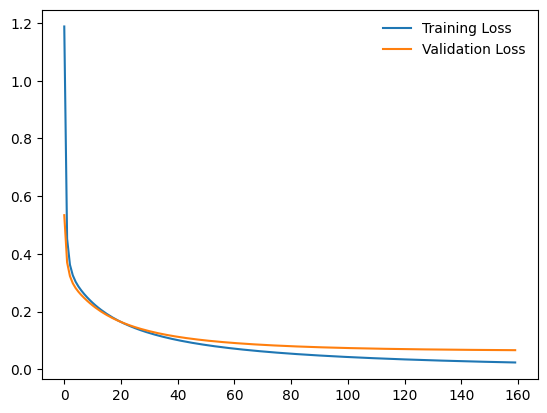

In [ ]:
plt.plot(train_loss_hist, label = 'Training Loss')
plt.plot(test_loss_hist, label = 'Validation Loss')
plt.legend(frameon = False)

## Вывод: Модель сошлась. Это видно на тестовом лоссе, потому что изменение стало очень маленьким

## 5) Сравните несколько архитектур, в том числе с различным количеством слоёв и подберите оптимальную. Обязательно используйте dropout и batchnorm и поясните свои выводы. Также можно попробовать различные активации в скрытых слоях.

## Я попробую 6 различных архитектур и проверю на 30 эпохах. В каждой будет dropout И batchnorm. Также попробую одну модель без droupout и batchnorm, чтобы посмотреть насколько они влияют на модель

In [ ]:
class Mnist_nn(nn.Module):
  def __init__(self):
    super().__init__()
    self.flat = nn.Flatten()
    self.linear1 = nn.Linear(28*28, 100)
    self.linear2 = nn.Linear(100, 10)
    self.act = nn.ReLU()

  def forward(self, x):
    out = self.flat(x)
    out = self.linear1(out)
    out = self.act(out)
    out = self.linear2(out)

    return out
model = Mnist_nn()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
BATCH_SIZE = 100
NUM_EPOCHS = 30

train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE)
test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE)

steps = 0
print_every = 200
train_loss_hist = []
test_loss_hist = []
preds_hist = []
labels_hist = []

for e in range(NUM_EPOCHS):
    running_loss = 0
    for images, labels in train_loader:
        steps += 1
        optimizer.zero_grad()
        preds = model(images.type(torch.FloatTensor).to(device))
        labels = labels.to(device)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if steps % print_every == 0:
            accuracy = 0
            test_loss = 0
            with torch.no_grad():
                model.eval()
                for images, labels in test_loader:
                    preds = model(images.type(torch.FloatTensor).to(device))
                    labels = labels.to(device)
                    labels_hist.extend(np.squeeze(labels.numpy()))
                    test_loss += loss_fn(preds, labels)
                    ps = torch.exp(preds)

                    top_p, top_class = ps.topk(1, dim = 1)
                    equals = top_class == labels.view(*top_class.shape)
                    preds_list.extendnp.squeeze((top_class.cpu().numpy()))
                    preds_hist.extend(np.squeeze(top_class.numpy()))
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            model.train()

            train_loss_hist.append(running_loss/len(train_loader))
            test_loss_hist.append(test_loss/len(test_loader))

            print("Epoch: {}/{}.. ".format(e + 1, NUM_EPOCHS),
                  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)),
                  "Loss: {:.3f}".format(test_loss/len(test_loader)))
            print(metrics.classification_report(preds_hist,labels_hist))

Epoch: 1/30..  Test Accuracy: 0.887 Loss: 0.424
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       998
           1       0.98      0.94      0.96      1172
           2       0.88      0.87      0.88      1034
           3       0.88      0.86      0.87      1029
           4       0.80      0.94      0.86       828
           5       0.81      0.84      0.82       865
           6       0.92      0.93      0.92       949
           7       0.88      0.93      0.90       972
           8       0.84      0.84      0.84       975
           9       0.91      0.78      0.84      1178

    accuracy                           0.89     10000
   macro avg       0.88      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Epoch: 1/30..  Test Accuracy: 0.904 Loss: 0.336
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      2053
           1       0.98      0.95   

## Теперь сделаем такую же модель, но с batchorm и dropout, также попробуем другие модели![изображение_2024-03-27_030058614.png](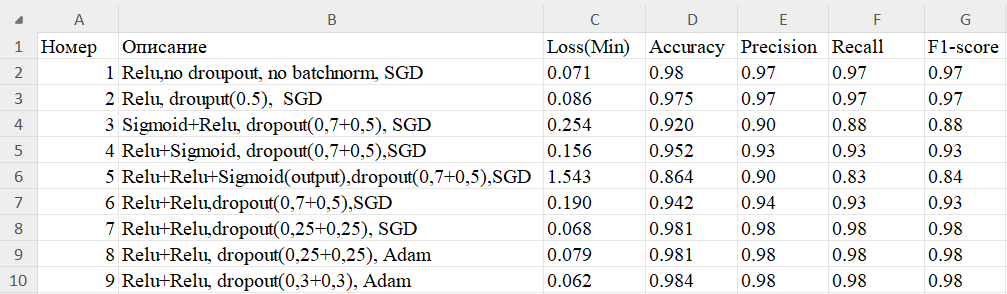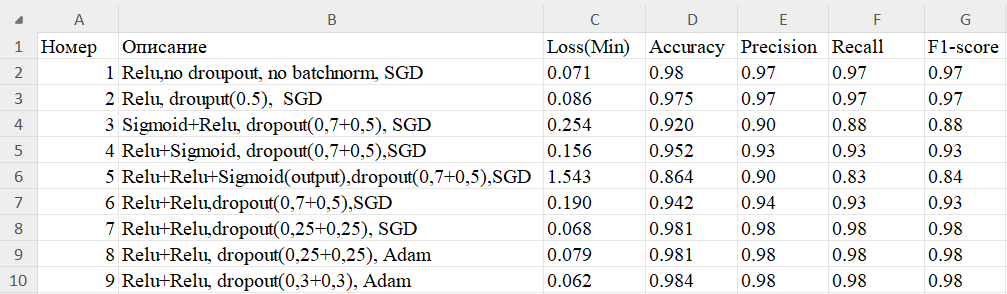)

In [ ]:
class Mnist_nn(nn.Module):
  def __init__(self):
    super().__init__()
    self.flat = nn.Flatten()
    self.linear1 = nn.Linear(28*28, 100)
    self.drop = nn.Dropout(p=0.5)
    self.linear2 = nn.Linear(100, 10)
    self.batch = nn.BatchNorm1d(100)
    self.act = nn.ReLU()

  def forward(self, x):
    out = self.flat(x)
    out = self.linear1(out)
    out = self.batch(out)
    out = self.drop(out)
    out = self.act(out)
    out = self.linear2(out)
    return out
model = Mnist_nn()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
BATCH_SIZE = 100
NUM_EPOCHS = 30

train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE)
test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE)

steps = 0
print_every = 200
train_loss_hist = []
test_loss_hist = []
preds_hist = []
labels_hist = []

for e in range(NUM_EPOCHS):
    running_loss = 0
    for images, labels in train_loader:
        steps += 1
        optimizer.zero_grad()
        preds = model(images.type(torch.FloatTensor).to(device))
        labels = labels.to(device)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if steps % print_every == 0:
            accuracy = 0
            test_loss = 0
            with torch.no_grad():
                model.eval()
                for images, labels in test_loader:
                    preds = model(images.type(torch.FloatTensor).to(device))
                    labels = labels.to(device)
                    labels_hist.extend(np.squeeze(labels.numpy()))
                    test_loss += loss_fn(preds, labels)
                    ps = torch.exp(preds)

                    top_p, top_class = ps.topk(1, dim = 1)
                    equals = top_class == labels.view(*top_class.shape)
                    preds_hist.extend(np.squeeze(top_class.numpy()))
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            model.train()

            train_loss_hist.append(running_loss/len(train_loader))
            test_loss_hist.append(test_loss/len(test_loader))

            print("Epoch: {}/{}.. ".format(e + 1, NUM_EPOCHS),
                  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)),
                  "Loss: {:.3f}".format(test_loss/len(test_loader)))
            print(metrics.classification_report(preds_hist,labels_hist))

Epoch: 1/30..  Test Accuracy: 0.916 Loss: 0.298
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1006
           1       0.98      0.92      0.95      1212
           2       0.90      0.92      0.91      1012
           3       0.90      0.90      0.90      1008
           4       0.94      0.91      0.92      1015
           5       0.87      0.90      0.88       863
           6       0.95      0.94      0.95       964
           7       0.90      0.93      0.92       998
           8       0.84      0.91      0.87       905
           9       0.89      0.89      0.89      1017

    accuracy                           0.92     10000
   macro avg       0.91      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Epoch: 1/30..  Test Accuracy: 0.931 Loss: 0.240
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      2020
           1       0.98      0.94   

In [ ]:
class Mnist_nn(nn.Module):
  def __init__(self):
    super().__init__()
    self.flat = nn.Flatten()
    self.linear1 = nn.Linear(28*28, 100)
    self.drop1 = nn.Dropout(p=0.7)
    self.drop2 = nn.Dropout(p=0.5)
    self.linear2 = nn.Linear(100, 100)
    self.batch = nn.BatchNorm1d(100)
    self.act = nn.Sigmoid()
    self.linear3 = nn.Linear(100,10)
    self.act2 = nn.ReLU()

  def forward(self, x):
    out = self.flat(x)
    out = self.linear1(out)
    out = self.batch(out)
    out = self.drop1(out)
    out = self.act(out)
    out = self.linear2(out)
    out = self.batch(out)
    out = self.drop2(out)
    out = self.act2(out)
    out = self.linear3(out)
    return out
model = Mnist_nn()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
BATCH_SIZE = 100
NUM_EPOCHS = 30

train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE)
test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE)

steps = 0
print_every = 200
train_loss_hist = []
test_loss_hist = []
preds_hist = []
labels_hist = []
device = 'cpu'

for e in range(NUM_EPOCHS):
    running_loss = 0
    for images, labels in train_loader:
        steps += 1
        optimizer.zero_grad()
        preds = model(images.type(torch.FloatTensor).to(device))
        labels = labels.to(device)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if steps % print_every == 0:
            accuracy = 0
            test_loss = 0
            with torch.no_grad():
                model.eval()
                for images, labels in test_loader:
                    preds = model(images.type(torch.FloatTensor).to(device))
                    labels = labels.to(device)
                    labels_hist.extend(np.squeeze(labels.numpy()))
                    test_loss += loss_fn(preds, labels)
                    ps = torch.exp(preds)

                    top_p, top_class = ps.topk(1, dim = 1)
                    equals = top_class == labels.view(*top_class.shape)
                    preds_hist.extend(np.squeeze(top_class.numpy()))
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            model.train()

            train_loss_hist.append(running_loss/len(train_loader))
            test_loss_hist.append(test_loss/len(test_loader))

            print("Epoch: {}/{}.. ".format(e + 1, NUM_EPOCHS),
                  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)),
                  "Loss: {:.3f}".format(test_loss/len(test_loader)))
            print(metrics.classification_report(preds_hist,labels_hist))

Epoch: 1/30..  Test Accuracy: 0.835 Loss: 0.488
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      1099
           1       0.87      0.99      0.93      1004
           2       0.86      0.86      0.86      1037
           3       0.92      0.77      0.84      1207
           4       0.52      0.97      0.67       521
           5       0.65      0.95      0.77       609
           6       0.84      0.97      0.90       825
           7       0.85      0.93      0.89       940
           8       0.89      0.71      0.79      1220
           9       0.94      0.61      0.74      1538

    accuracy                           0.84     10000
   macro avg       0.83      0.86      0.83     10000
weighted avg       0.86      0.84      0.84     10000

Epoch: 1/30..  Test Accuracy: 0.870 Loss: 0.403
              precision    recall  f1-score   support

           0       0.98      0.89      0.94      2154
           1       0.88      0.99   

In [ ]:
class Mnist_nn(nn.Module):
  def __init__(self):
    super().__init__()
    self.flat = nn.Flatten()
    self.linear1 = nn.Linear(28*28, 100)
    self.drop1 = nn.Dropout(p=0.7)
    self.drop2 = nn.Dropout(p=0.5)
    self.linear2 = nn.Linear(100, 100)
    self.batch = nn.BatchNorm1d(100)
    self.act = nn.Sigmoid()
    self.linear3 = nn.Linear(100,10)
    self.act2 = nn.ReLU()

  def forward(self, x):
    out = self.flat(x)
    out = self.linear1(out)
    out = self.batch(out)
    out = self.drop1(out)
    out = self.act2(out)
    out = self.linear2(out)
    out = self.batch(out)
    out = self.drop2(out)
    out = self.act(out)
    out = self.linear3(out)
    return out
model = Mnist_nn()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
BATCH_SIZE = 100
NUM_EPOCHS = 30

train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE)
test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE)

steps = 0
print_every = 200
train_loss_hist = []
test_loss_hist = []
preds_hist = []
labels_hist = []
device = 'cpu'

for e in range(NUM_EPOCHS):
    running_loss = 0
    for images, labels in train_loader:
        steps += 1
        optimizer.zero_grad()
        preds = model(images.type(torch.FloatTensor).to(device))
        labels = labels.to(device)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if steps % print_every == 0:
            accuracy = 0
            test_loss = 0
            with torch.no_grad():
                model.eval()
                for images, labels in test_loader:
                    preds = model(images.type(torch.FloatTensor).to(device))
                    labels = labels.to(device)
                    labels_hist.extend(np.squeeze(labels.numpy()))
                    test_loss += loss_fn(preds, labels)
                    ps = torch.exp(preds)

                    top_p, top_class = ps.topk(1, dim = 1)
                    equals = top_class == labels.view(*top_class.shape)
                    preds_hist.extend(np.squeeze(top_class.numpy()))
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            model.train()

            train_loss_hist.append(running_loss/len(train_loader))
            test_loss_hist.append(test_loss/len(test_loader))

            print("Epoch: {}/{}.. ".format(e + 1, NUM_EPOCHS),
                  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)),
                  "Loss: {:.3f}".format(test_loss/len(test_loader)))
            print(metrics.classification_report(preds_hist,labels_hist))

Epoch: 1/30..  Test Accuracy: 0.835 Loss: 1.597
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      1059
           1       0.97      0.93      0.95      1183
           2       0.87      0.78      0.82      1145
           3       0.86      0.75      0.80      1164
           4       0.66      0.97      0.78       669
           5       0.44      0.96      0.60       412
           6       0.94      0.89      0.92      1012
           7       0.81      0.96      0.88       873
           8       0.83      0.79      0.81      1031
           9       0.93      0.65      0.77      1452

    accuracy                           0.83     10000
   macro avg       0.83      0.86      0.83     10000
weighted avg       0.87      0.83      0.84     10000

Epoch: 1/30..  Test Accuracy: 0.832 Loss: 1.145
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      2023
           1       0.93      0.95   

In [ ]:
class Mnist_nn(nn.Module):
  def __init__(self):
    super().__init__()
    self.flat = nn.Flatten()
    self.linear1 = nn.Linear(28*28, 100)
    self.drop1 = nn.Dropout(p=0.7)
    self.drop2 = nn.Dropout(p=0.5)
    self.linear2 = nn.Linear(100, 100)
    self.batch = nn.BatchNorm1d(100)
    self.act = nn.Sigmoid()
    self.linear3 = nn.Linear(100,10)
    self.act2 = nn.ReLU()

  def forward(self, x):
    out = self.flat(x)
    out = self.linear1(out)
    out = self.batch(out)
    out = self.drop1(out)
    out = self.act2(out)
    out = self.linear2(out)
    out = self.batch(out)
    out = self.drop2(out)
    out = self.act2(out)
    out = self.linear3(out)
    out = self.act(out)
    return out
model = Mnist_nn()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
BATCH_SIZE = 100
NUM_EPOCHS = 30

train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE)
test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE)

steps = 0
print_every = 200
train_loss_hist = []
test_loss_hist = []
preds_hist = []
labels_hist = []
device = 'cpu'

for e in range(NUM_EPOCHS):
    running_loss = 0
    for images, labels in train_loader:
        steps += 1
        optimizer.zero_grad()
        preds = model(images.type(torch.FloatTensor).to(device))
        labels = labels.to(device)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if steps % print_every == 0:
            accuracy = 0
            test_loss = 0
            with torch.no_grad():
                model.eval()
                for images, labels in test_loader:
                    preds = model(images.type(torch.FloatTensor).to(device))
                    labels = labels.to(device)
                    labels_hist.extend(np.squeeze(labels.numpy()))
                    test_loss += loss_fn(preds, labels)
                    ps = torch.exp(preds)

                    top_p, top_class = ps.topk(1, dim = 1)
                    equals = top_class == labels.view(*top_class.shape)
                    preds_hist.extend(np.squeeze(top_class.numpy()))
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            model.train()

            train_loss_hist.append(running_loss/len(train_loader))
            test_loss_hist.append(test_loss/len(test_loader))

            print("Epoch: {}/{}.. ".format(e + 1, NUM_EPOCHS),
                  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)),
                  "Loss: {:.3f}".format(test_loss/len(test_loader)))
            print(metrics.classification_report(preds_hist,labels_hist))

Epoch: 1/30..  Test Accuracy: 0.788 Loss: 2.021
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       937
           1       0.93      0.96      0.95      1095
           2       0.80      0.79      0.79      1038
           3       0.94      0.48      0.64      1973
           4       0.81      0.86      0.84       931
           5       0.23      0.99      0.37       206
           6       0.91      0.90      0.91       967
           7       0.75      0.96      0.85       804
           8       0.62      0.82      0.71       743
           9       0.89      0.69      0.78      1306

    accuracy                           0.79     10000
   macro avg       0.78      0.84      0.78     10000
weighted avg       0.85      0.79      0.80     10000

Epoch: 1/30..  Test Accuracy: 0.825 Loss: 1.866
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1836
           1       0.93      0.96   

In [ ]:
class Mnist_nn(nn.Module):
  def __init__(self):
    super().__init__()
    self.flat = nn.Flatten()
    self.linear1 = nn.Linear(28*28, 100)
    self.drop1 = nn.Dropout(p=0.7)
    self.drop2 = nn.Dropout(p=0.5)
    self.linear2 = nn.Linear(100, 100)
    self.batch = nn.BatchNorm1d(100)
    self.act = nn.Sigmoid()
    self.linear3 = nn.Linear(100,10)
    self.act2 = nn.ReLU()

  def forward(self, x):
    out = self.flat(x)
    out = self.linear1(out)
    out = self.batch(out)
    out = self.drop1(out)
    out = self.act2(out)
    out = self.linear2(out)
    out = self.batch(out)
    out = self.drop2(out)
    out = self.act2(out)
    out = self.linear3(out)
    return out
model = Mnist_nn()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
BATCH_SIZE = 100
NUM_EPOCHS = 30

train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE)
test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE)

steps = 0
print_every = 200
train_loss_hist = []
test_loss_hist = []
preds_hist = []
labels_hist = []
device = 'cpu'

for e in range(NUM_EPOCHS):
    running_loss = 0
    for images, labels in train_loader:
        steps += 1
        optimizer.zero_grad()
        preds = model(images.type(torch.FloatTensor).to(device))
        labels = labels.to(device)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if steps % print_every == 0:
            accuracy = 0
            test_loss = 0
            with torch.no_grad():
                model.eval()
                for images, labels in test_loader:
                    preds = model(images.type(torch.FloatTensor).to(device))
                    labels = labels.to(device)
                    labels_hist.extend(np.squeeze(labels.numpy()))
                    test_loss += loss_fn(preds, labels)
                    ps = torch.exp(preds)

                    top_p, top_class = ps.topk(1, dim = 1)
                    equals = top_class == labels.view(*top_class.shape)
                    preds_hist.extend(np.squeeze(top_class.numpy()))
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            model.train()

            train_loss_hist.append(running_loss/len(train_loader))
            test_loss_hist.append(test_loss/len(test_loader))

            print("Epoch: {}/{}.. ".format(e + 1, NUM_EPOCHS),
                  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)),
                  "Loss: {:.3f}".format(test_loss/len(test_loader)))
            print(metrics.classification_report(preds_hist,labels_hist))

Epoch: 1/30..  Test Accuracy: 0.872 Loss: 0.645
              precision    recall  f1-score   support

           0       0.98      0.91      0.95      1054
           1       0.90      0.98      0.94      1045
           2       0.87      0.89      0.88      1014
           3       0.90      0.84      0.87      1075
           4       0.89      0.89      0.89       979
           5       0.65      0.95      0.77       608
           6       0.91      0.94      0.92       924
           7       0.79      0.95      0.86       855
           8       0.92      0.68      0.78      1314
           9       0.89      0.79      0.84      1132

    accuracy                           0.87     10000
   macro avg       0.87      0.88      0.87     10000
weighted avg       0.88      0.87      0.87     10000

Epoch: 1/30..  Test Accuracy: 0.873 Loss: 0.522
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      2024
           1       0.90      0.98   

In [ ]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(28*28, 128)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.25)
        self.linear2 = nn.Linear(128, 64)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.25)
        self.linear3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.batch_norm1(self.linear1(x)))
        x = self.dropout1(x)
        x = F.relu(self.batch_norm2(self.linear2(x)))
        x = self.dropout2(x)
        x = self.linear3(x)
        return x
model = MnistModel()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
BATCH_SIZE = 100
NUM_EPOCHS = 30

train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE)
test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE)

steps = 0
print_every = 200
train_loss_hist = []
test_loss_hist = []
preds_hist = []
labels_hist = []
device = 'cpu'

for e in range(NUM_EPOCHS):
    running_loss = 0
    for images, labels in train_loader:
        steps += 1
        optimizer.zero_grad()
        preds = model(images.type(torch.FloatTensor).to(device))
        labels = labels.to(device)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if steps % print_every == 0:
            accuracy = 0
            test_loss = 0
            with torch.no_grad():
                model.eval()
                for images, labels in test_loader:
                    preds = model(images.type(torch.FloatTensor).to(device))
                    labels = labels.to(device)
                    labels_hist.extend(np.squeeze(labels.numpy()))
                    test_loss += loss_fn(preds, labels)
                    ps = torch.exp(preds)

                    top_p, top_class = ps.topk(1, dim = 1)
                    equals = top_class == labels.view(*top_class.shape)
                    preds_hist.extend(np.squeeze(top_class.numpy()))
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            model.train()

            train_loss_hist.append(running_loss/len(train_loader))
            test_loss_hist.append(test_loss/len(test_loader))

            print("Epoch: {}/{}.. ".format(e + 1, NUM_EPOCHS),
                  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)),
                  "Loss: {:.3f}".format(test_loss/len(test_loader)))
            print(metrics.classification_report(preds_hist,labels_hist))

Epoch: 1/30..  Test Accuracy: 0.930 Loss: 0.244
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1000
           1       0.99      0.95      0.97      1184
           2       0.92      0.93      0.92      1024
           3       0.91      0.92      0.92       998
           4       0.95      0.91      0.93      1025
           5       0.90      0.90      0.90       891
           6       0.94      0.96      0.95       938
           7       0.93      0.93      0.93      1027
           8       0.89      0.93      0.91       924
           9       0.90      0.92      0.91       989

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

Epoch: 1/30..  Test Accuracy: 0.945 Loss: 0.181
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      2014
           1       0.99      0.95   

In [ ]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(28*28, 128)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.25)
        self.linear2 = nn.Linear(128, 64)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.25)
        self.linear3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.batch_norm1(self.linear1(x)))
        x = self.dropout1(x)
        x = F.relu(self.batch_norm2(self.linear2(x)))
        x = self.dropout2(x)
        x = self.linear3(x)
        return x
model = MnistModel()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
BATCH_SIZE = 100
NUM_EPOCHS = 30

train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE)
test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE)

steps = 0
print_every = 200
train_loss_hist = []
test_loss_hist = []
preds_hist = []
labels_hist = []
device = 'cpu'

for e in range(NUM_EPOCHS):
    running_loss = 0
    for images, labels in train_loader:
        steps += 1
        optimizer.zero_grad()
        preds = model(images.type(torch.FloatTensor).to(device))
        labels = labels.to(device)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if steps % print_every == 0:
            accuracy = 0
            test_loss = 0
            with torch.no_grad():
                model.eval()
                for images, labels in test_loader:
                    preds = model(images.type(torch.FloatTensor).to(device))
                    labels = labels.to(device)
                    labels_hist.extend(np.squeeze(labels.numpy()))
                    test_loss += loss_fn(preds, labels)
                    ps = torch.exp(preds)

                    top_p, top_class = ps.topk(1, dim = 1)
                    equals = top_class == labels.view(*top_class.shape)
                    preds_hist.extend(np.squeeze(top_class.numpy()))
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            model.train()

            train_loss_hist.append(running_loss/len(train_loader))
            test_loss_hist.append(test_loss/len(test_loader))

            print("Epoch: {}/{}.. ".format(e + 1, NUM_EPOCHS),
                  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)),
                  "Loss: {:.3f}".format(test_loss/len(test_loader)))
            print(metrics.classification_report(preds_hist,labels_hist))

Epoch: 1/30..  Test Accuracy: 0.931 Loss: 0.267
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1011
           1       0.99      0.94      0.96      1194
           2       0.92      0.94      0.93      1012
           3       0.91      0.92      0.92      1009
           4       0.95      0.92      0.94      1008
           5       0.90      0.91      0.90       882
           6       0.95      0.96      0.96       954
           7       0.92      0.92      0.92      1026
           8       0.87      0.94      0.90       900
           9       0.91      0.91      0.91      1004

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

Epoch: 1/30..  Test Accuracy: 0.950 Loss: 0.175
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      2022
           1       0.99      0.95   

In [ ]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(28*28, 256)
        self.batch_norm1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.3)
        self.linear2 = nn.Linear(256, 128)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)
        self.linear3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.leaky_relu(self.batch_norm1(self.linear1(x)))
        x = self.dropout1(x)
        x = F.leaky_relu(self.batch_norm2(self.linear2(x)))
        x = self.dropout2(x)
        x = self.linear3(x)
        return x
model = MnistModel()


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
BATCH_SIZE = 100
NUM_EPOCHS = 30

train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE)
test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE)

steps = 0
print_every = 200
train_loss_hist = []
test_loss_hist = []
preds_hist = []
labels_hist = []
device = 'cpu'

for e in range(NUM_EPOCHS):
    running_loss = 0
    for images, labels in train_loader:
        steps += 1
        optimizer.zero_grad()
        preds = model(images.type(torch.FloatTensor).to(device))
        labels = labels.to(device)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if steps % print_every == 0:
            accuracy = 0
            test_loss = 0
            with torch.no_grad():
                model.eval()
                for images, labels in test_loader:
                    preds = model(images.type(torch.FloatTensor).to(device))
                    labels = labels.to(device)
                    labels_hist.extend(np.squeeze(labels.numpy()))
                    test_loss += loss_fn(preds, labels)
                    ps = torch.exp(preds)

                    top_p, top_class = ps.topk(1, dim = 1)
                    equals = top_class == labels.view(*top_class.shape)
                    preds_hist.extend(np.squeeze(top_class.numpy()))
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            model.train()

            train_loss_hist.append(running_loss/len(train_loader))
            test_loss_hist.append(test_loss/len(test_loader))

            print("Epoch: {}/{}.. ".format(e + 1, NUM_EPOCHS),
                  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)),
                  "Loss: {:.3f}".format(test_loss/len(test_loader)))
            print(metrics.classification_report(preds_hist,labels_hist))

Epoch: 1/30..  Test Accuracy: 0.942 Loss: 0.204
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1018
           1       0.99      0.96      0.97      1172
           2       0.93      0.94      0.94      1015
           3       0.93      0.93      0.93      1007
           4       0.96      0.92      0.94      1024
           5       0.93      0.93      0.93       893
           6       0.95      0.97      0.96       942
           7       0.93      0.94      0.94      1019
           8       0.90      0.96      0.93       913
           9       0.91      0.92      0.92       997

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

Epoch: 1/30..  Test Accuracy: 0.954 Loss: 0.146
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      2026
           1       0.99      0.97   

# Выводы
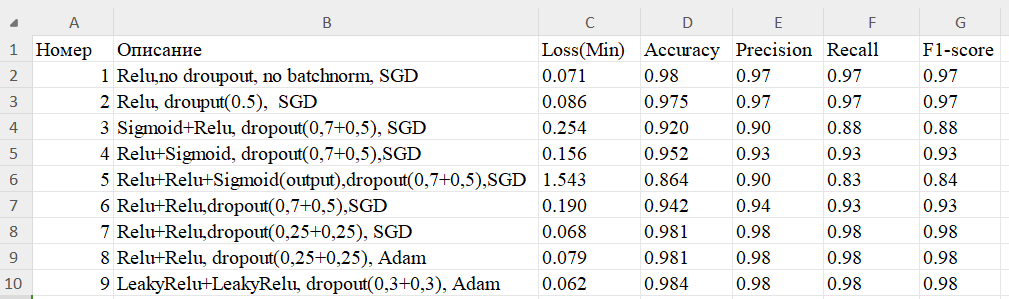
В первом номере не использовались dropout и batchnorm, в 7 и далее номерах я изменил количество input И output layers на 128 и 64 соответственно. Во время исследования были испробованы 9 различных моделей с различными видами оптимизаторов, архитектур, значений dropout и количеств параметров. Наилучший результат показал 9 номер с Relu+Relu, dropout 0.3 и оптимизатором Adam. Значения Accuracy и Precision - 0.984 и 0.062 соответственно. Остальные метрики имеют значения 0.98. Это наилучшая получившаяся модель нейронной сети с двумя скрытыми слоями. Табличка Эксель есть в файлах

Я считаю, что эта архитектура стала наилучшей, потому что в ней есть ряд преимуществ. Первое это наличие batchnorm, что нормализует и стабилизирует процесс обучения. Второе это наличие dropout с значением 0.3, так как оно предотвращает переобучение. Третье это количество скрытых слоев - 2, конечно можно сделать их больше и тем самым сделать модель более сложной, однако даже два слоя отлично справляются с этой задачей. Четвертое это функция активации LeakyReLU, потому что она избегает появление мертвых нейронов за счет того, что LeakyReLu допускает небольшой градиент когда нейрон не активен. Ненулевой наклон для отрицательных входных данных в некоторых случаях может привести к более быстрой сходимости, поскольку позволяет избежать проблемы нулевого градиента для отрицательных входных данных. В заключении, это задача отлично справляется с задачей датасета MNIST. Конечно, она еще далека от идеала, но имеющиеся данные(например акураси) довольно хороши.